In [29]:
import xarray as xr
import numpy as np
import datetime
from datetime import date, timedelta
import netCDF4
import matplotlib.pyplot as plt # matplotlib version 3.2 and custom version 3.3
import proplot as plot
import cartopy

#### Read ERAI data 

In [30]:
fil_Z500a_erai='/cw3e/mead/projects/cwp137/UFS/UFS_proto6_anomZ500ERAI_79-19_1.5.nc'
ds_Z500a_erai=xr.open_dataset(fil_Z500a_erai)
erai_time_in = ds_Z500a_erai['time']
erai_yyyymmdd = np.array ( erai_time_in.dt.year * 10000 + erai_time_in.dt.month * 100 + erai_time_in.dt.day )
erai_anomaly=ds_Z500a_erai['z']
era_lat_in=ds_Z500a_erai['lat']
era_lon_in=ds_Z500a_erai['lon']

#### Read model data

In [31]:
## Prototype 5
fil_Z500a_ufs5='/cw3e/mead/projects/cwp137/UFS/Z500_interp_UFS_proto5_20110401-20180315_anomaly.nc'
ds_Z500a_ufs5=xr.open_dataset(fil_Z500a_ufs5)
model_anomaly_ufs5=ds_Z500a_ufs5['z500']

## Prototype 6
fil_Z500a_ufs6='/cw3e/mead/projects/cwp137/UFS/Z500_interp_UFS_proto6_20110401-20180315_anomaly.nc'
ds_Z500a_ufs6=xr.open_dataset(fil_Z500a_ufs6)
model_anomaly_ufs6=ds_Z500a_ufs6['z500']

model_yyyymmdd=ds_Z500a_ufs5['initial_date']

#### Read ERAI RMM data

In [32]:
fil_rmm_erai='/cw3e/mead/projects/cwp137/UFS/rmm_ERA-Interim.nc'
ds_rmm=xr.open_dataset(fil_rmm_erai,decode_times=False)
times=ds_rmm['amplitude'].time
init_time=date(1960,1,1)+timedelta(int(times[0]))
time=[]
for i in range(len(times)):
        time.append(init_time+timedelta(i))
phase=np.array(ds_rmm['phase'])
amplitude=np.array(ds_rmm['amplitude'])
phase_int = np.array(list(map(np.int_, phase)))

#### Convert time

In [33]:
import pandas as pd
import datetime
ds_rmm['time'] = pd.to_datetime(time,format="%Y/%m/%d")
rmm_time_in = ds_rmm['time']
rmm_yyyymmdd = np.array ( rmm_time_in.dt.year * 10000 + rmm_time_in.dt.month * 100 + rmm_time_in.dt.day )
model_time_in = ds_Z500a_ufs5['initial_date']
model_yyyymmdd = np.array ( model_time_in.dt.year * 10000 + model_time_in.dt.month * 100 + model_time_in.dt.day )

#### Find events for pattern correlation

In [34]:
composite_start_month = 11
composite_end_month   = 3
compoiste_amplitude_threshold = 1.
phase_names = [ "8-1" , "2-3" , "4-5" , "6-7" ]
def get_rmm_composite_list ( composite_phase_names , model_yyyymmdd , rmm_yyyymmdd , rmm_phase_in , rmm_amplitude_in , amplitude_threshold , start_month , end_month ) :
    rmm_list = [ ]
    for phase_n in range ( len ( composite_phase_names ) ) : rmm_list.append ( [ ] )
    if start_month > end_month :
        for time_step in range ( len ( model_yyyymmdd ) ) :
            month_now = model_yyyymmdd [ time_step ] // 100 % 100
            if month_now >= start_month or month_now <= end_month :
                time_n = 0
                while rmm_yyyymmdd [ time_n ] < model_yyyymmdd [ time_step ] : time_n = time_n + 1
                if rmm_amplitude_in [ time_n ] > amplitude_threshold :
                    rmm_list [ rmm_phase_in [ time_n ] // 2 % 4 ].append ( time_step )
    else :
        for time_step in range ( len ( model_yyyymmdd ) ) :
            month_now = model_yyyymmdd [ time_step ] // 100 % 100
            if month_now >= start_month and month_now <= end_month :
                time_n = 0
                while rmm_yyyymmdd [ time_n ] < model_yyyymmdd [ time_step ] : time_n = time_n + 1
                if rmm_amplitude_in [ time_n ] > amplitude_threshold :
                    rmm_list [ rmm_phase_in [ time_n ] // 2 % 4 ].append ( time_step )
    return rmm_list

In [35]:
rmm_list = get_rmm_composite_list ( phase_names , model_yyyymmdd , rmm_yyyymmdd , phase_int , amplitude , compoiste_amplitude_threshold , composite_start_month , composite_end_month )

In [36]:
timelag=ds_Z500a_ufs5['time']
rmm_list_ERA_67 = [ ]
rmm_tem_list_67=rmm_list[3] 
rmm_list_ERA_67 = np.empty (( len (timelag),len (rmm_tem_list_67)) ,dtype=int)
time_n=0
erai_time_in = ds_Z500a_erai['time']
erai_yyyymmdd = np.array ( erai_time_in.dt.year * 10000 + erai_time_in.dt.month * 100 + erai_time_in.dt.day )
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_list_67 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd[rmm_tem_list_67 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_ERA_67 [itime,time_n-1]=time_step+itime

In [37]:
rmm_list_ERA_23 = [ ]
rmm_tem_list_23=rmm_list[1] 
rmm_list_ERA_23 = np.empty (( len (timelag),len (rmm_tem_list_23)) ,dtype=int)
time_n=0
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_list_23 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd[rmm_tem_list_23 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_ERA_23 [itime,time_n-1]=time_step+itime

#### Calculate pattern correlation

In [38]:
def correlate(obs,model,lat_min,lat_max,lon_min,lon_max):
    x=obs.sel(lat=slice(lat_max,lat_min),lon=slice(lon_min,lon_max))
    y=model.sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min,lon_max))
    x_stacked=x.stack(grid=('lat','lon'))
    y_stacked=y.stack(grid=('latitude','longitude'))
    corr=np.corrcoef(x_stacked,y_stacked)
    
    return corr

In [39]:
def patterncc(timelag,rmm_list_ERA,rmm_list_model,modeldata,eraidata):
    nn=len(rmm_list_ERA[0,:])
    pcc=np.empty( ( len (timelag),nn) ,dtype=float)
    for inumber in range (len(rmm_list_ERA[0,:])):
        for itime in range (len (timelag)):
            model_z500_temp=modeldata [ rmm_list_model[inumber], itime, : , : ]
            erai_anomaly_temp=eraidata [ rmm_list_ERA[itime,inumber], : , : ]
            res_temp=correlate(erai_anomaly_temp,
                model_z500_temp,lat_min,lat_max,lon_min,lon_max)
            pcc[itime,inumber]=res_temp[0,1]
    return pcc

In [40]:
lat_min=20
lat_max=80
lon_min=120
lon_max=300
rmm_list_model_67=rmm_list [3]
rmm_list_model_23=rmm_list [1]

## Prototype 5 pattern CC
pcc_ufs5_p23 = patterncc(timelag,rmm_list_ERA_23,rmm_list_model_23,model_anomaly_ufs5,erai_anomaly)
pcc_ufs5_p67 = patterncc(timelag,rmm_list_ERA_67,rmm_list_model_67,model_anomaly_ufs5,erai_anomaly)       
pcc_ufs5_p23=np.mean ( pcc_ufs5_p23,axis= 1   )
pcc_ufs5_p67=np.mean ( pcc_ufs5_p67,axis= 1   )

## Prototype 6 pattern CC
pcc_ufs6_p23 = patterncc(timelag,rmm_list_ERA_23,rmm_list_model_23,model_anomaly_ufs6,erai_anomaly)
pcc_ufs6_p67 = patterncc(timelag,rmm_list_ERA_67,rmm_list_model_67,model_anomaly_ufs6,erai_anomaly)       
pcc_ufs6_p23=np.mean ( pcc_ufs6_p23,axis= 1   )
pcc_ufs6_p67=np.mean ( pcc_ufs6_p67,axis= 1   )

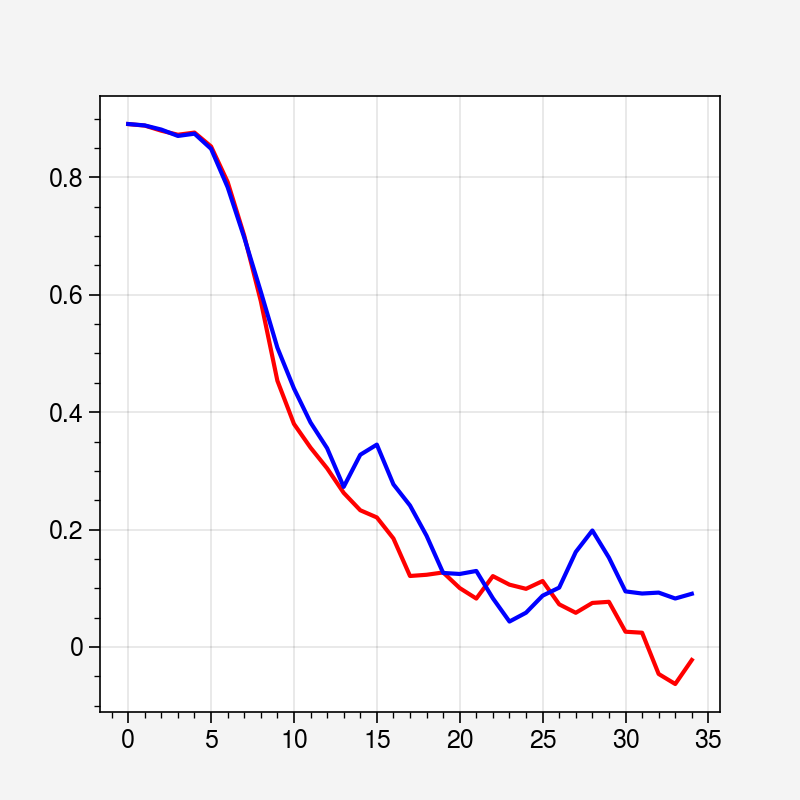

In [41]:
plt.plot(pcc_ufs5_p67, c = 'red')
plt.plot(pcc_ufs6_p67, c = 'blue')
plt.show()

#### Calculate amplitude metric

In [44]:
import math
def amplitude_metric(timelag,rmm_list_ERA,rmm_list_model,modeldata,eraidata,lat_min,lat_max,lon_min,lon_max):
    nn=len(rmm_list_ERA[0,:])
    amp=np.empty( ( len (timelag),nn) ,dtype=float)
    for inumber in range (len(rmm_list_ERA[0,:])):
        for itime in range (len (timelag)):
            model_z500_temp=modeldata [ rmm_list_model[inumber], itime, : , : ]
            erai_anomaly_temp=eraidata [ rmm_list_ERA[itime,inumber], : , : ]
            x=erai_anomaly_temp.sel(lat=slice(lat_max,lat_min),lon=slice(lon_min,lon_max))
            y=model_z500_temp.sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min,lon_max))
            x_stacked=x.stack(grid=('lat','lon'))
            y_stacked=y.stack(grid=('latitude','longitude'))
            model_z500_variance_temp=np.var(y_stacked)
            erai_anomaly_variance_temp=np.var(x_stacked)
            amp[itime,inumber]=math.sqrt(model_z500_variance_temp/erai_anomaly_variance_temp)
    return amp

In [45]:
## Prototype 5 amplitude metric
amp_ufs5_p23 = amplitude_metric(timelag,rmm_list_ERA_23,rmm_list_model_23,model_anomaly_ufs5,erai_anomaly,lat_min,lat_max,lon_min,lon_max)
amp_ufs5_p67 = amplitude_metric(timelag,rmm_list_ERA_67,rmm_list_model_67,model_anomaly_ufs5,erai_anomaly,lat_min,lat_max,lon_min,lon_max)       
amp_ufs5_p23=np.mean ( amp_ufs5_p23,axis= 1   )
amp_ufs5_p67=np.mean ( amp_ufs5_p67,axis= 1   )

## Prototype 6 amplitude metric
amp_ufs6_p23 = amplitude_metric(timelag,rmm_list_ERA_23,rmm_list_model_23,model_anomaly_ufs6,erai_anomaly,lat_min,lat_max,lon_min,lon_max)
amp_ufs6_p67 = amplitude_metric(timelag,rmm_list_ERA_67,rmm_list_model_67,model_anomaly_ufs6,erai_anomaly,lat_min,lat_max,lon_min,lon_max)       
amp_ufs6_p23=np.mean ( amp_ufs6_p23,axis= 1   )
amp_ufs6_p67=np.mean ( amp_ufs6_p67,axis= 1   )

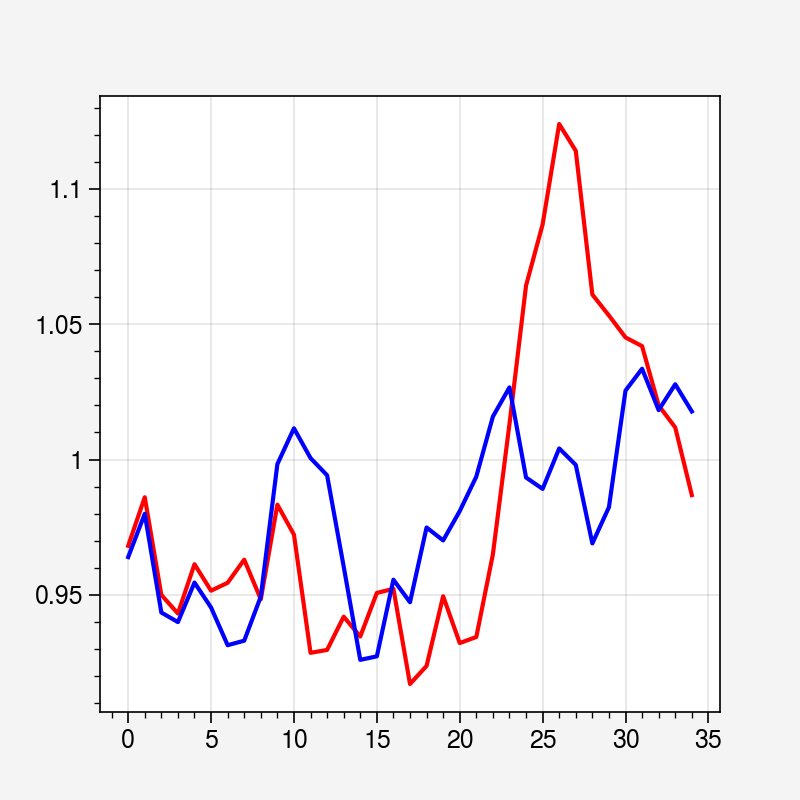

In [50]:
plt.plot(amp_ufs5_p23, c = 'red')
plt.plot(amp_ufs6_p23, c = 'blue')
plt.show()